In [13]:
import numpy as np
import math
import json
import random

def waveforms(N_A, N_g, N_f, t0_tf, T, B, trials, seedn=1, inputfile="input", phi0=0, A0=1, 
              Af=50, g0=0, gf=2, F0=90, Ff=110, N=1000):
    """
    METHOD
    ======
    Takes parameter inputs of a wave and the strength and duration of
    noise, and combines the two to form a data for each trial.
    
    PARAMETERS
    ==========
    N_A : (Int) Number of potential amplitudes
    N_g : (Int) Number of potential gammas
    N_f : (Int) Number of potential frequencies
    t0_tf : (Float) Time duration of signal
    T : (Float) Time stamp of the end time of the data. Default = None
    B : (Float) Noise amplitude of waveform
    trials : (Int) Number of different waveforms to make
    inputfile : (String) Name of json file produced containing each trial's parameters and data
    phi0 : (Float) Initial phase of the signal. Default = 0.0
    A0, Af : (Float) Amplitude lower/upper bounds
    g0, gf : (Float) Gamma lower/upper bounds
    F0, Ff : (Float) Frequency lower/upper bounds
    N : (Int) Divisions in total time series 
    
    OUTPUT
    ======
    A dictionary is created with a component for each trial, consisting
    of a list of the parameters used to create the data, and a list of
    the data. This is stored in a newly written json file.
    
    """
    
    # initalizes the arrays which span parameter space, and their lengths
    A_RANGE=np.linspace(A0,Af,N_A)
    G_RANGE=np.linspace(g0,gf,N_g)
    F_RANGE=np.linspace(F0,Ff,N_f)

    # number of parameters available
    A_LEN, G_LEN, F_LEN = N_A, N_g, N_f
    
    waveform_data={}
    for j in range(trials):
        waveform_data.update({j:[[],[]]})
        
        # calculates random indice for each parameter (A, f, g)
        A_RAN=random.randint(0,A_LEN-1)
        G_RAN=random.randint(0,G_LEN-1)
        F_RAN=random.randint(0,F_LEN-1)
        
        # calculates random parameters A, f, g
        A, gamma, f = A_RANGE[A_RAN], G_RANGE[G_RAN], F_RANGE[F_RAN]
        
        dt=T/N # time resolution

        t0=(T-t0_tf)*np.random.random(1)[0]  # randomly generate start time
        START_INDEX=math.floor(t0/dt)        # find index associated with time

        ##NOTE: using 't0' instead of some multiple of dt may cause issues later
        
        SIG_LEN = (math.floor(t0_tf/dt)+1 if (t0_tf != T) else N) # calculate # of indexes signal takes
        INJECTED = np.zeros(N)                 # initalize injected signal, with N size array of zeroes
        for i in range(SIG_LEN):
            INJECTED[START_INDEX + i]=t0+i*dt       # fill in injected signal with its time stamps

        w = 2 * np.pi * f
        
        # replace timestamps with their displacement values
        SR = INJECTED[START_INDEX : START_INDEX+SIG_LEN][:]
        INJECTED[START_INDEX : START_INDEX+SIG_LEN] = A*np.sin(w*(SR) + phi0)*np.exp(-gamma*(SR-t0))
        
        # Purposed for Quadrature Sum
        D_i = [] # list of each differently seeded waveform
        for n in range(seedn):
            np.random.seed(seed = n)
            NOISE = -B+2*B*np.random.random(N)  # noise!
            D_i.append(list(NOISE + INJECTED))  # complete data!
        
        # gets parameters and data for each trial, stuffs it into dictionary
        parameters = [A, f, gamma, t0]
        waveform_data[j][0], waveform_data[j][1] = parameters, D_i
        
    # each trial has list of parameters used and list of data values
    with open("{}-waveform_data.json".format(inputfile) , "w") as f:
        json.dump(waveform_data, f, indent=2, sort_keys=True)

In [14]:
#  N_A, N_g, N_f, t0_tf, T, B, trials
waveforms(4, 4, 4, 4, 10, 10, 10, N=250, seedn=2)

In [35]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import math
import time
import operator

class OnSource:
    
    def __init__(self, N_A, N_g, N_f, t0_tf, T, trials, seedn = 1, inputfile="input", outputfile="output",
                 A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N_t=1000):

        """
        METHOD
        ======
        Unpacks waveform json file to obtain each trial's parameters
        and data values. Generates a set of wave templates spanning 
        the parameter space of amplitude, frequency and gamma. 
        Creates cross-correlation/chi-squared stats with each trial's
        data and templates.
        
        PARAMETERS:
        ==========        
        N_A : (Int) Number of potential amplitudes
        N_g : (Int) Number of potential gammas
        N_f : (Int) Number of potential frequencies
        t0_tf : (Float) Time duration of signal
        T : (Float) Time stamp of the end time of the data. Default = None
        trials : (Int) Number of different waveforms to make
        inputfile : (String) Name of json file read containing each trial's parameters and data
        outputfile : (String) Name of json file written containing each trial's data parameters, data values, and base statistics values
        A0, Af : (Float) Amplitude lower/upper bounds
        g0, gf : (Float) Gamma lower/upper bounds
        F0, Ff : (Float) Frequency lower/upper bounds
        N_t : (Int) Divisions in total time series 
        
        OUTPUT
        ======
        Stores internally the base statistics, detection probability statistics, and
        false alarm probabality statistics, and can create plots of these statistics.
        
        """
        
        # initalizes the arrays which span parameter space, and their lengths
        self.A_RANGE=np.linspace(A0,Af,N_A)
        self.G_RANGE=np.linspace(g0,gf,N_g)
        self.F_RANGE=np.linspace(F0,Ff,N_f)
        
        self.A_LEN, self.G_LEN, self.F_LEN = len(self.A_RANGE), len(self.G_RANGE), len(self.F_RANGE)
                
        # constructs timestep resolution, and saves N and t0/tf internally 
        self.N, self.dt, self.t0_tf= N_t, T/N_t, t0_tf
        
        # constructs time range to pick injected signal start time from/ corresponding length 
        self.t_RANGE=np.linspace(0,T-(t0_tf),int(N_t*(1-((t0_tf)/T))))
        self.t_LEN=len(self.t_RANGE)

        # initialize arrays for various data/cross-correlations/chi-squares 
        self.noise = []
        self.cross_cor = []
        self.chi = []
        
        # constructs all templates which correspond to points in the parameter space
        self.TEMPLATES_AGF=[ self.template( A, f, g, t0_tf, self.dt) for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
        
        self.AGF_PAIR=[ [A, f, g] for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
        
        # NEW ADDITION: Reads waveform data file 
        with open("{}-waveform_data.json".format(inputfile),"r") as f: 
            waveform_data = json.load(f)
        
        self.waveform_data = waveform_data
        
        self.trials=trials
        output={}
            
        for i in range(trials):            
            
            output.update({i:[[],[],[],[]]})
            
            # isolates random a-g-f pair / data set # NEW ADDITION
            temp_AGFT, data = waveform_data[str(i)][0], waveform_data[str(i)][1]
            
            self.noise.append(data) 
            
            output[i][0], output[i][1] = temp_AGFT, data  # stores random a-g-f pair / data set 
            
            Quad_CRS = []
            Quad_CHI = []
            # performs base static calculation across parameter space
            # Quadrature Sum
            for n in range(seedn): # Use seedn as index for data
                
                CRS_COR, CHI_SQR = [[],[]]
                
                for template in self.TEMPLATES_AGF:

                    CC_dh = list(self.CrossCorrelation(data[n], template, self.dt))
                    CRS_COR.append(CC_dh)

                    CS_dh = list(self.ChiSquare(data[n], template, self.dt))
                    CHI_SQR.append(CS_dh)
                
                Quad_CRS.append(CRS_COR) # now a 3d list of seedn statistics, with 2d list statistics per waveform
                Quad_CHI.append(CHI_SQR)
                
            CRS_COR = np.sum(np.array(Quad_CRS) ** 2, axis = 0) ** .5 # Quadrature sum of each seed's statistic
            CHI_SQR = np.sum(np.array(Quad_CHI) ** 2, axis = 0) ** .5
            
            # stores base statistics to attribute
            self.cross_cor.append(CRS_COR)
            self.chi.append(CHI_SQR)
            output[i][2], output[i][3] = CRS_COR, CHI_SQR
        
        # sets output as a attribute
        self.output = output
        
        # saves 'output' as a .json in current working directory.
        '''with open("{}.json".format(outputfile), "w") as f:
            json.dump(output, f, indent=2, sort_keys=True)'''
    
    # calculates test statistic, stores it internally, and returns a copy of it as a dictionary 
    def rho(self, stat=None):
        
        # NEW ADDITION: String to equation!
        if stat == None:
            stat = "CC_IJ/(1+CS_IJ)"
            
        # counts number of tempates in parameter space
        PSPACE_LEN = len(self.AGF_PAIR)
    
        # initalizes rho statistic dictionary
        self.RHO = {}
        # indexed to loops through dataset trials
        for i in range(self.trials):
            rho_i = []
        
            # indexed to loops through parameter space templates and
            # calculates each rho_ij given template j
            for j in range(PSPACE_LEN):
                CC_IJ = np.array(self.cross_cor[i][j][:])
                CS_IJ = np.array(self.chi[i][j][:])
                
                # NEW ADDITION: Evaluates string (Exec gave issues... eval is the same concept though)
                p = eval(stat)
                rho_i.append(list(p))
            self.RHO.update({ i : rho_i })
        
        self.stat = stat
        
        return self.RHO
    
    def modulator(self, rho_ij, D): # D: foreground/background interval length
        
        rho_mod_D, RHO_ij = [] , rho_ij[:]
        
        # size of window, length of statistic values
        dn , L = math.floor(2*D/self.dt), len(RHO_ij)
                    
        for i in range(0,L-(L%dn),dn):
            rho_mod_D.append(max(RHO_ij[i:i+dn]))

        if (L-(L%dn)) != L :
            rho_mod_D.append(max(RHO_ij[L-(L%dn):L]))
        
        return rho_mod_D
    
    def window(self, D):
        
        if (2*D >= self.dt):
            
            self.RHO_MOD = {}
            find_thresh = []
            for i in range(self.trials):

                # gets the length
                TEMP_LEN = len(self.cross_cor[i])
                
                # seperates fg value from bg value
                T0_2D = math.floor(self.output[i][0][3]/(2*D))
                
                BG_VALS_IJ, FG_VAL_IJ = [], []
                for j in range(TEMP_LEN):
                
                    # calculates bg values + fg values
                    BG_VALS_IJ.append(self.modulator( self.RHO[i][j][:],D))

                    FG_VAL_IJ.append(BG_VALS_IJ[j].pop(T0_2D))
                    
                find_thresh += FG_VAL_IJ # 1d list of all forground values 
                self.RHO_MOD.update({ i: [ BG_VALS_IJ, FG_VAL_IJ ] }) # these are the peaks we look for
            
            self.pot_thresh0 = min(find_thresh) # Used to set thresholds in ROC Curve
            self.pot_threshf = max(find_thresh)
            return self.RHO_MOD
        
        else: 
            print("invalid D; it is required that 2*D >= T/N")

# test_plotter and scatter_plotter may be combinable by using arguments to trigger the creation of specific graphs
# that is if we are always gonna be making these scatter plots

    def test_plotter(self, T0, Tf, N, new_stat_only=True, index=0, outputfile="test"):
    
        # initalizes threshold axis points, counts for each threshold
        # and space of parameter space
        THRS_AXIS = []
        COUNT_AXIS = []
        PSPACE_LEN = len(self.AGF_PAIR)
        PSACE_PAIRS = []
        
        # NEW ADDITION: Stats per threshold
        self.Detection_Prob = []
        self.New_False_Prob = []

        # sets current threshold value
        # NEW ADDITION: thrshld will need to actually decrease in order to find smallest chi-square
        thrshlds = np.linspace(T0,Tf,N)
        
        for thrshld in thrshlds:

            # NEW ADDITION: Detection/ False Alarm probability counters
            Detect_count = 0
            False_count = 0

            #loops from trial/ parameter space pairs 
            for i in range(self.trials):
                heat_count = 0
                
                # Detection Probability
                Max_FG_ij = max(self.RHO_MOD[i][1]) # max of onsources per trial
                if Max_FG_ij > thrshld:
                    Detect_count += 1
                    
                for j in range(PSPACE_LEN):

                    RM_ij = np.array(self.RHO_MOD[i][0][j])
                    FG_ij = self.RHO_MOD[i][1][j]
                    N_BG_ij = len(RM_ij[RM_ij > FG_ij])
                    
                    # NEW ADDITION: False Alarm probability
                    falses_ij = len(RM_ij[RM_ij > thrshld])
                    False_count += falses_ij

            # NEW ADDITION: Detection/False Alarm probability stats
            Detect_stat = Detect_count / self.trials
            False_stat = False_count / (len(self.RHO_MOD[i][0][0]) * PSPACE_LEN * self.trials)

            # NEW ADDITION: Appending stat per threshold
            self.Detection_Prob.append(Detect_stat)
            self.New_False_Prob.append(False_stat)

    def ROC_Curve(self, n_s, N, new_stat_only=True, outputfile="ROC_test"):
        
        # Choose soley n-rho's or an addition stat
        if new_stat_only == True:
            stat_list = []
        else:
            stat_list = ["CC_IJ","CS_IJ"]
            
        # different ^n rhos are appended
        for n in range(1,n_s+1):
            rho = "CC_IJ/((1+abs(CS_IJ))**{})".format(n)
            stat_list.append(rho)
        
        stat_length = len(stat_list)
        for s in range(stat_length):
    
            self.rho(stat = stat_list[s])
            self.window(.02)
            self.test_plotter(self.pot_thresh0, self.pot_threshf, N)
            plt.plot(self.New_False_Prob, self.Detection_Prob, label=stat_list[s])
            
        plt.xlabel("New_False_Probs")
        plt.ylabel("Detection_Probs")
        plt.title("ROC Curve:n's={}:N={}".format(n_s,N))
        plt.legend()
        plt.savefig("{}-ROC.png".format(outputfile))
        plt.show()

    # Produces a template given a position in parameter space
    def template(self, A, f, gamma, duration, dt):
        t = np.arange(0, duration + dt, dt)
        w = 2 * np.pi * f
        return A * np.sin(w*t)*np.exp(-gamma*t)
    
    # Produces a cross correlation function given a data input and a template in parameter space
    def CrossCorrelation(self, data, template, dt):
        ii = 0
        M = []
        
        while len(data[ii:]) >= len(template):
            M.append(np.sum((data[ii: len(template) + ii] * template)))
            ii+=1
        
        return M
         
    # Produces chi square at each "slide"
    def ChiSquare(self, data, template, dt):
        ii = 0
        C = []
        
        while len(data[ii:]) >= len(template):
            C.append(-1 * np.sum((data[ii: len(template) + ii] - template) ** 2))
            ii += 1
            
        return C

In [36]:
# N_A, N_g, N_f, t0_tf, T, trials, filename, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N_t=1000
x = OnSource(4, 4, 4, 4, 10, 10, N_t=250, seedn=2)

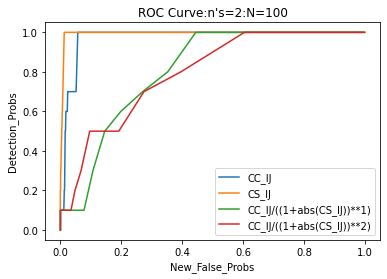

In [37]:
x.ROC_Curve(2, 100, new_stat_only=False)

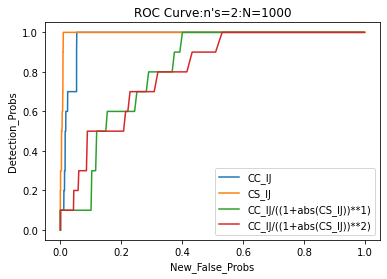

In [31]:
# n_s, N -(3 - 4)
x.ROC_Curve(2, 1000, new_stat_only=False)

In [382]:
x.pot_thresh0

0.0004044946219040512

In [383]:
x.pot_threshf

2.969904569313706